In [12]:
import numpy as np
import matplotlib.pyplot as plt
from quantum_tunneling.workflows import run_bound_states
from quantum_tunneling.viz import plot_potential_and_states
from quantum_tunneling.observables import forbidden_probability

In [13]:
# Choose a potential; tweak parameters as needed.
potentials = {
    "cusp": {"kind": "cusp", "params": {"V0": 20.0, "alpha": 0.5}},
    "exp_well": {"kind": "exp_well", "params": {"V0": 5.0, "a": 1.0}},
    "soft_barrier": {"kind": "soft_barrier", "params": {"V0": 5.0}},
    "rough": {"kind": "rough", "params": {"V0": 1.0, "k0": 0.6, "levels": 4, "decay": 0.6}},
}
pot_key = "cusp"  # change to exp_well / soft_barrier / rough
cfg = {
    "potential": potentials[pot_key],
    "grid": {"L": 30.0, "N": 1200},
    "solver": {"k": 6, "hbar": 1.0, "m": 1.0},
}
cfg

{'potential': {'kind': 'cusp', 'params': {'V0': 20.0, 'alpha': 0.5}},
 'grid': {'L': 30.0, 'N': 1200},
 'solver': {'k': 6, 'hbar': 1.0, 'm': 1.0}}

In [14]:
res = run_bound_states(cfg)

E = res["E"]
x = res['x']
Vx = res['Vx']
psi = res['psi']
dx = res['dx']

metrics = res["metrics"]
forbidden = res["forbidden"]


In [15]:
print("Bound-state summary (n, E, sigma, IPR, forbidden prob)")
for n, En in enumerate(E):
    m = metrics[n]
    fp = forbidden[n]
    print(f"n={n}, E={En:.4f}, sigma={m['sigma']:.3f}, ipr={m['ipr']:.4f}, P_forbid={fp:.4f}")

Bound-state summary (n, E, sigma, IPR, forbidden prob)
n=0, E=10.1745, sigma=0.256, ipr=1.1573, P_forbid=0.3017
n=1, E=17.5236, sigma=0.573, ipr=0.6102, P_forbid=0.1668
n=2, E=21.1289, sigma=0.838, ipr=0.4876, P_forbid=0.1441
n=3, E=24.3724, sigma=1.105, ipr=0.3948, P_forbid=0.1086
n=4, E=26.8105, sigma=1.341, ipr=0.3475, P_forbid=0.1069
n=5, E=29.1499, sigma=1.579, ipr=0.3058, P_forbid=0.0895


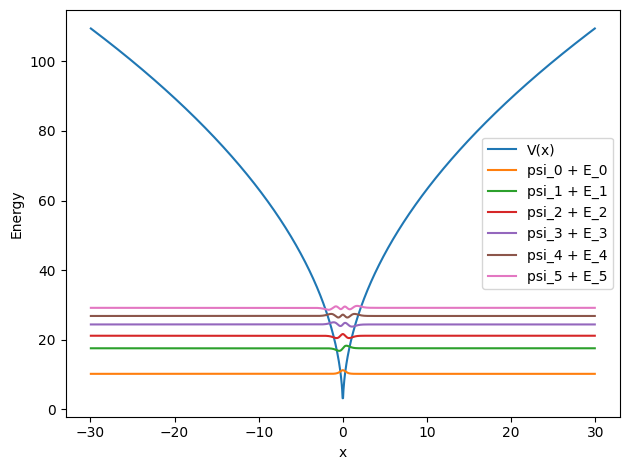

In [16]:
plot_potential_and_states(x, Vx, E, psi, scale=0.8)
plt.show()

# How the exotic shape influences localization?

We define how localized the wavefunction is by two metrics: $\langle x^2 \rangle$ and the inverse participation ratio (ipr).

We scan different $V_0$ values for the cusp potential and observe how $\langle x^2 \rangle$ and ipr change for the ground state.



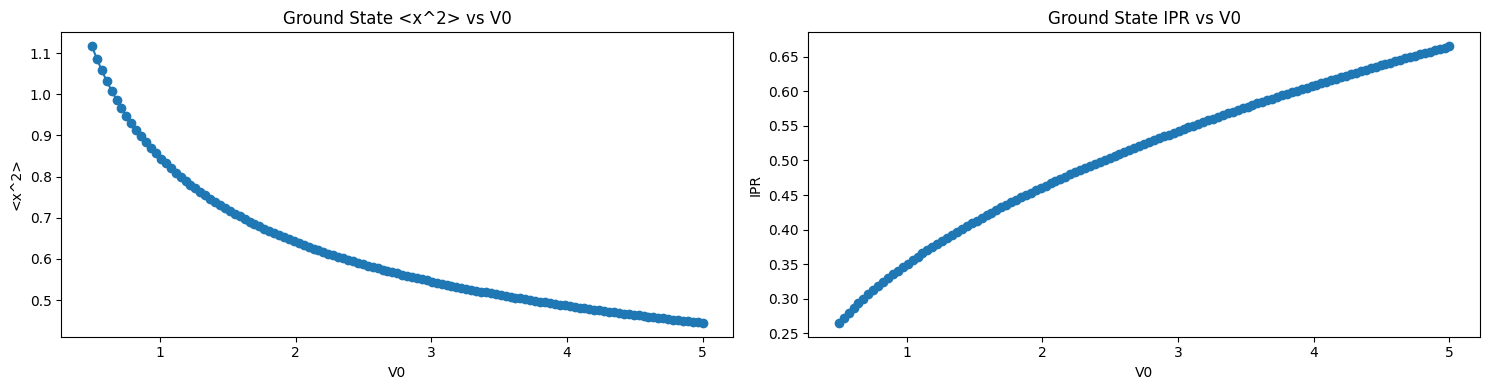

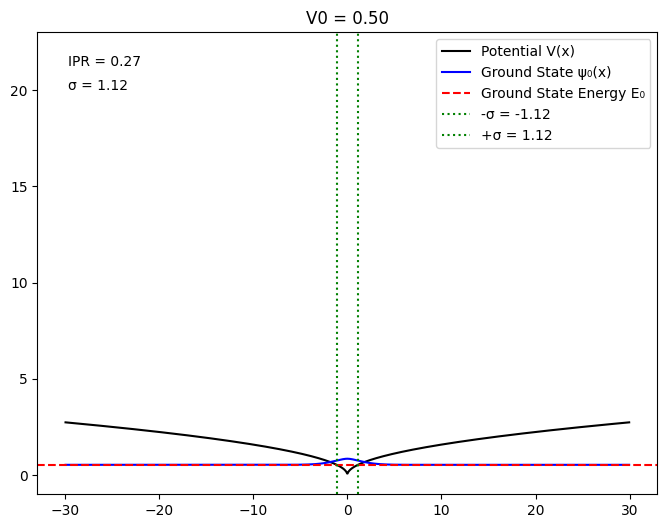

In [17]:
V_0s = np.linspace(0.5, 5.0, 125)
sigmas = []
iprs = []
Vxs = []
psis = []
E0s = []
for V_0 in V_0s:
    cfg["potential"]["params"]["V0"] = V_0
    res = run_bound_states(cfg)
    sigma = res["metrics"][0]["sigma"]  # ground state
    sigmas.append(sigma)
    ipr = res["metrics"][0]["ipr"]  # ground state
    iprs.append(ipr)
    Vxs.append(res['Vx'])
    psis.append(res['psi'][:,0])
    E0s.append(res['E'][0])
    

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
# plot ipr vs V0
axs[1].set_title("Ground State IPR vs V0")
axs[1].plot(V_0s, iprs, marker='o')
axs[1].set_xlabel("V0")
axs[1].set_ylabel("IPR")
# plot sigma vs V0
axs[0].set_title("Ground State <x^2> vs V0")
axs[0].plot(V_0s, sigmas, marker='o')
axs[0].set_xlabel("V0")
axs[0].set_ylabel("<x^2>")
plt.tight_layout()
plt.show()

# plot shape of the potential, ground state wavefunction, and metrics for all V0s
# save in the form of sequence frame
# fix y from -1 to 23
import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(8, 6))
def update(frame):
    ax.cla()
    ax.set_ylim(-1, 23)
    # 2. plot potential
    Vx = Vxs[frame]
    psi = psis[frame]
    V0 = V_0s[frame]
    E0 = E0s[frame]
    ax.plot(res['x'], Vx, label='Potential V(x)', color='black')
    # 3. plot wavefunction (scaled and shifted)
    ax.plot(res['x'], psi * 0.5 + E0, label='Ground State ψ₀(x)', color='blue')
    # 4. plot energy level
    ax.axhline(E0, color='red', linestyle='--', label='Ground State Energy E₀')
    ax.set_title(f"V0 = {V0:.2f}")
    
    # 5. plot sigma as two vertical lines
    sigma = sigmas[frame]
    ax.axvline(-sigma, color='green', linestyle=':', label=f'-σ = {-sigma:.2f}')
    ax.axvline(sigma, color='green', linestyle=':', label=f'+σ = {sigma:.2f}')
    # 6. add ipr and sigma text
    ipr = iprs[frame]
    ax.text(0.05, 0.95, f"IPR = {ipr:.2f}", transform=ax.transAxes, verticalalignment='top')
    ax.text(0.05, 0.90, f"σ = {sigma:.2f}", transform=ax.transAxes, verticalalignment='top')
    ax.legend()
# save to gif
ani = animation.FuncAnimation(fig, update, frames=len(V_0s), repeat=False)
ani.save('ground_state_evolution.gif', writer='pillow', fps=25)




## Discussion

![](ground_state_evolution.gif)

From the animation as well as other plots, we can see that as we increase the depth of the potential well (increasing \( V_0 \)), the ground state wavefunction becomes more localized around the center of the well.

# The dependence of forbidden-region penetration on $n$

Let us fix $V_0$ and scan different energy levels $n$ to see how the penetration behaviors in forbidden region changes with $n$.

Penetration behaviors include:

1. Probability of bounded state in forbidden region: $ P_{\text{forbidden}} = \int_{|x| > a} |\psi(x)|^2 dx $
2. Penetration depth: The distance into the forbidden region where the probability density drops to $ \frac{1}{e} $ of its maximum value.
3. Decay rate

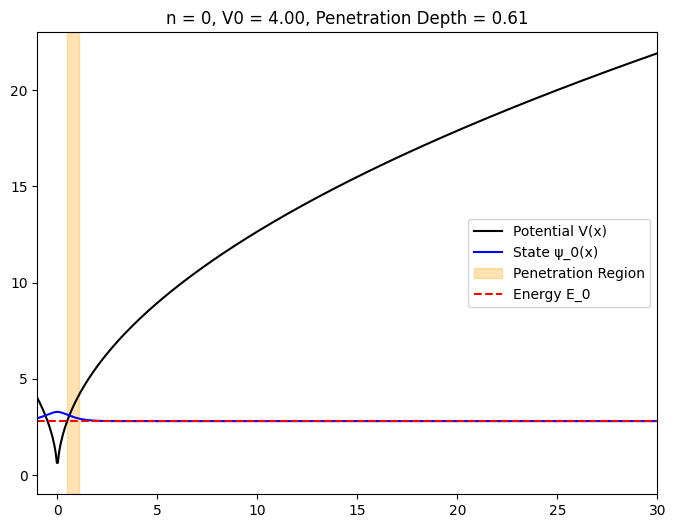

In [18]:
from quantum_tunneling.observables import forbidden_probability
from quantum_tunneling.util import find_roots
forbidden_probs = []
penetration_depths = []
penetration_regions = []
decay_rates = []
V0_fixed = 4.0

cfg["potential"]["params"]["V0"] = V0_fixed

k = 24
cfg["solver"]["k"] = k
ns = range(0, k)
res = run_bound_states(cfg)
E = res["E"]
metrics = res["metrics"]
forbidden = res["forbidden"]
for n in ns:
    # 1. compute forbidden probability
    # forbidden_probability(Vx: Array, En: float, psi: Array, dx: float) -> float:
    psi_n = res['psi'][:, n]
    fp = forbidden_probability(res['Vx'], res['E'][n], psi_n, res['dx'])
    forbidden_probs.append(fp)
    
    # 2. compute penetration depth, which is defined as the distance from the turning point to the point where probability density drops to 1/e of its maximum value
    # find_roots(x: Array,Vx: Array,E: float,x_min: Optional[float] = None, x_max: Optional[float] = None, atol: float = 1e-12, merge_tol: Optional[float] = None,) -> Array:
    tp = find_roots(res['x'], res['Vx'], res['E'][n])[-1]
    probability_density_just_enter_the_forbidden = psi_n[tp["idx"]]
    point_at_reverse_e_of_tp = find_roots(res['x'], psi_n, probability_density_just_enter_the_forbidden/np.e,x_min=tp["x"])[0]
    distance = point_at_reverse_e_of_tp["x"] - tp["x"]
    penetration_depths.append(distance)
    penetration_regions.append((tp["x"], point_at_reverse_e_of_tp["x"]))
    
    # 3. decay rate is simply (1-1/e) * max / penetration_depth
    decay_rate = np.abs((1 - 1/np.e) * probability_density_just_enter_the_forbidden / distance) # ABS IS IMPORTANT HERE!!!!!!!
    decay_rates.append(decay_rate)
    
# plot penetration regions on the wavefunctions in the form of animation
fig, ax = plt.subplots(figsize=(8, 6))
def update(frame):
    ax.cla()
    ax.set_ylim(-1, 23)
    ax.set_xlim(-1, cfg["grid"]["L"])
    # 2. plot potential
    Vx = res['Vx']
    psi = res['psi'][:, frame]
    V0 = V0_fixed
    E_n = res['E'][frame]
    ax.plot(res['x'], Vx, label='Potential V(x)', color='black')
    # 3. plot wavefunction (scaled and shifted)
    ax.plot(res['x'], psi * 0.5 + E_n, label=f'State ψ_{frame}(x)', color='blue')
    # plot penetration region
    tp, pp = penetration_regions[frame]
    ax.axvspan(tp, pp, color='orange', alpha=0.3, label='Penetration Region')
    # 4. plot energy level
    ax.axhline(E_n, color='red', linestyle='--', label=f'Energy E_{frame}')
    ax.set_title(f"n = {frame}, V0 = {V0:.2f}, Penetration Depth = {penetration_depths[frame]:.2f}")
    ax.legend()
# save to gif
ani = animation.FuncAnimation(fig, update, frames=len(ns), repeat=False)
ani.save('penetration_region_evolution.gif', writer='pillow', fps=1)

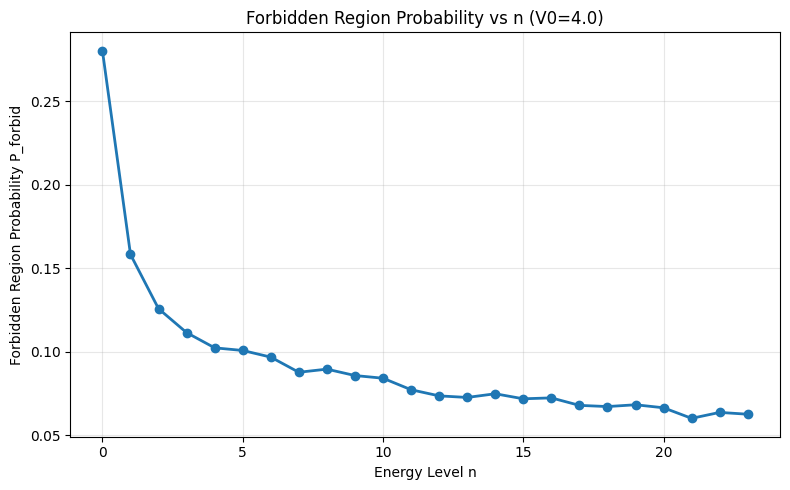

In [19]:
# plot forbidden prob vs n
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title(f"Forbidden Region Probability vs n (V0={V0_fixed})")
ax.plot(ns, forbidden_probs, marker='o', linewidth=2, markersize=6)
ax.set_xlabel("Energy Level n")
ax.set_ylabel("Forbidden Region Probability P_forbid")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

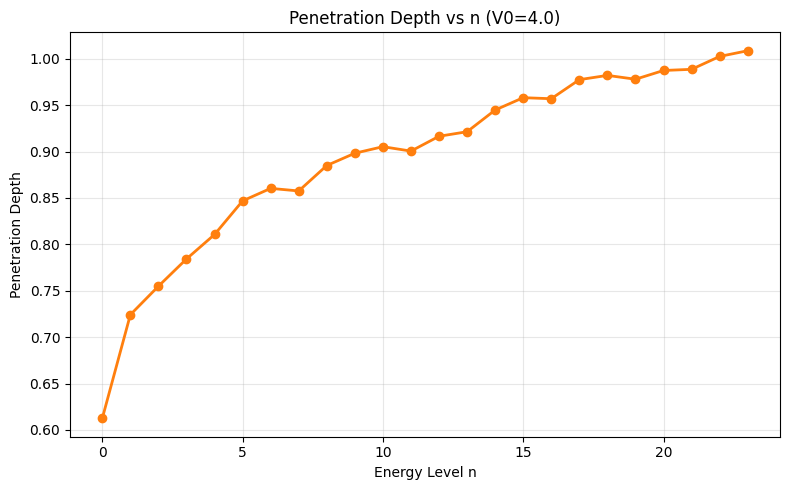

In [20]:
# plot penetration depth vs n
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title(f"Penetration Depth vs n (V0={V0_fixed})")
ax.plot(ns, penetration_depths, marker='o', linewidth=2, markersize=6, color='tab:orange')
ax.set_xlabel("Energy Level n")
ax.set_ylabel("Penetration Depth")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

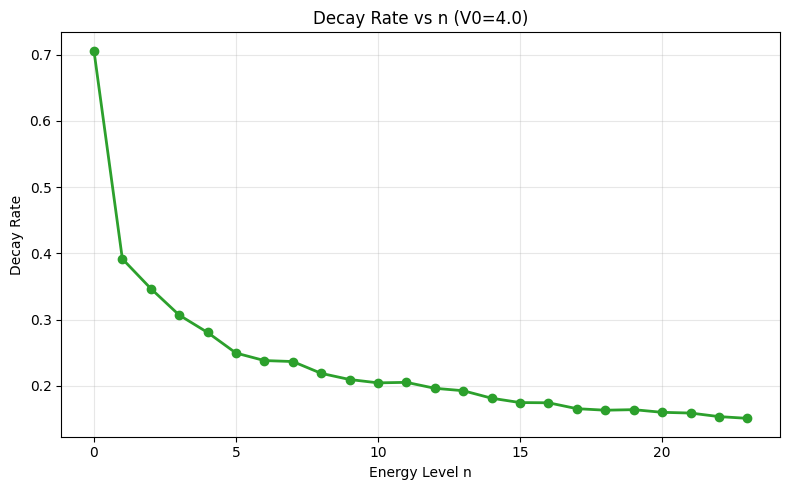

In [21]:
# plot decay rate vs n
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title(f"Decay Rate vs n (V0={V0_fixed})")
ax.plot(ns, decay_rates, marker='o', linewidth=2, markersize=6, color='tab:green')
ax.set_xlabel("Energy Level n")
ax.set_ylabel("Decay Rate")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Discussion

From the first plot, we can see that as the energy level $n$ increases, the forbidden region probability $ P_{\text{forbidden}} $ decreases. We consider that as the energy level increases, the potential well becomes wider so the wavefunction is more confined within the well, leading to a lower probability of finding the particle in the forbidden region.

From the second plot, we observe that the penetration depth increases with increasing energy level $n$. We think this is because as the energy level increases, the potential barrier becomes softer (less steep), allowing the wavefunction to extend further into the forbidden region before decaying significantly. Also because of this, the decay rate decreases with increasing energy level $n$, as seen in the third plot, which indicates that the wavefunction decays more strongly for steeper potential barriers.



## Notes
- Swap `pot_key` to compare shapes.
- Increase `N` or `L` if states leak to boundaries.
- Use `forbidden` and `sigma` trends to discuss localization changes.